<a href="https://colab.research.google.com/github/ariaalinejad/AN2DL-ImageClassification/blob/main/CNN_and_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook contains two different solutions to the classification problem. The first one is with a CNN made from scratch while the second is based on the pretrained network VGG16.**
*italicized text*


Here we connect the notebook to our drive and our files

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL/Homework1

Mounted at /gdrive
/gdrive/My Drive/AN2DL/Homework1


# libs

We install and import dependencies here.

In [ ]:
!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 13.4 MB/s eta 0:00:00


In [ ]:
#Libraries
import PIL # image processing and visualization
import tensorflow as tf # the AI library
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import keras_cv
from keras import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
from keras.applications.vgg16 import VGG16
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

warnings.filterwarnings("ignore")
tfk = tf.keras
tfkl = tf.keras.layers

Using TensorFlow backend


#Set seed

Setting seed is important for reproducability.

In [ ]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#Split Data

Here we define important parameters such as batch size, image size and where files are found, and we split the data at hand into a training set with 80% of the data and a validation set with 20% of the data.

In [ ]:
batch_size = 32
img_height = 96
img_width = 96
color_channels = 3
n_classes = 8
data_dir = '/gdrive/My Drive/AN2DL/Homework1/training_data_final'


train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  label_mode="categorical",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=None)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  label_mode="categorical",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names

train_ds_batched = train_ds.batch(batch_size) # make batched dataset for plotting use

Found 3542 files belonging to 8 classes.
Using 2834 files for training.
Found 3542 files belonging to 8 classes.
Using 708 files for validation.


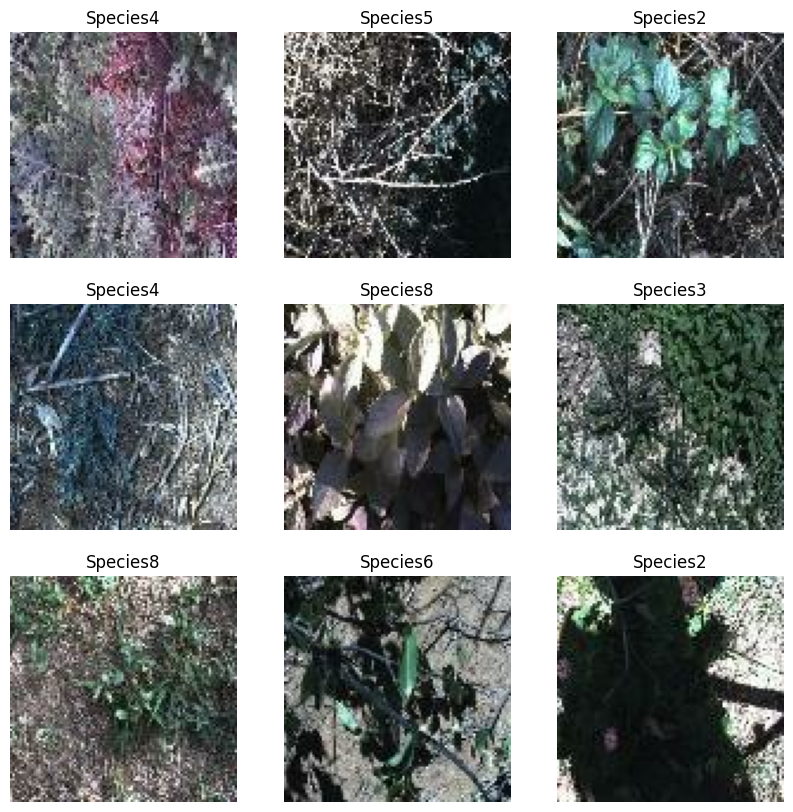

In [ ]:
# visualize some of the images in the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds_batched.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = int(np.where(labels[i].numpy()==1)[0]) # from one hot encoding back to index
    plt.title(class_names[index])
    plt.axis("off")

# CNN without transfer learning

## Data Augmentation

In [ ]:
data_augmentation = tfk.Sequential([
  tfkl.RandomFlip("horizontal_and_vertical"),
  tfkl.RandomRotation(0.2),
  tfkl.RandomContrast(0.2),
  tfkl.RandomZoom(0.2, 0.2)
])

In [ ]:
aug_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
train_and_aug_ds = train_ds.concatenate(aug_ds)

In [ ]:
aug_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
train_and_aug_ds = train_and_aug_ds.concatenate(aug_ds)

In [ ]:
train_and_aug_ds = train_and_aug_ds.shuffle(999999)

In [ ]:
train_and_aug_ds = train_and_aug_ds.batch(batch_size)

## Model Training


In [ ]:
input_layer = tfkl.Input(shape=(img_height, img_width, color_channels), name='Input')

norm1 = tfkl.Rescaling(1./255, input_shape=(img_height, img_width, color_channels))(input_layer)


conv1 = tfkl.Conv2D(
    filters=32,
    kernel_size=(3, 3),
    strides = (1, 1),
    padding = 'same',
    activation = 'relu',
    kernel_initializer = tfk.initializers.HeUniform(seed)
)(norm1)
pool1 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv1)


conv2 = tfkl.Conv2D(
    filters=64,
    kernel_size=(3, 3),
    strides = (1, 1),
    padding = 'same',
    activation = 'relu',
    kernel_initializer = tfk.initializers.HeUniform(seed)
)(pool1)
pool2 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv2)

conv3 = tfkl.Conv2D(
    filters=128,
    kernel_size=(3, 3),
    strides = (1, 1),
    padding = 'same',
    activation = 'relu',
    kernel_initializer = tfk.initializers.HeUniform(seed)
)(pool2)
pool3 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv3)

conv4 = tfkl.Conv2D(
    filters=256,
    kernel_size=(3, 3),
    strides = (1, 1),
    padding = 'same',
    activation = 'relu',
    kernel_initializer = tfk.initializers.HeUniform(seed)
)(pool3)
pool4 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv4)

conv5 = tfkl.Conv2D(
    filters=512,
    kernel_size=(3, 3),
    strides = (1, 1),
    padding = 'same',
    activation = 'relu',
    kernel_initializer = tfk.initializers.HeUniform(seed)
)(pool4)
pool5 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv5)


flattening_layer = tfkl.Flatten(name='Flatten')(pool5)

classifier_layer = tfkl.Dense(
    units=128,
    name='Classifier',
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed)
)(flattening_layer)

classifier_layer = tfkl.Dropout(0.5, seed=seed)(classifier_layer)
output_layer = tfkl.Dense(
    units=n_classes,
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed),
    name='Output'
)(classifier_layer)

# Connect input and output through the Model class
model = tfk.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(label_smoothing=0.1), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
# Return the model

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                         

In [ ]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v0.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping, patience is set to 20 to make sure the model can improve with such a high dropout rate.
#The earlystopping is here based on finding the minimum validation loss.
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

In [ ]:
epochs=40

vgg_history = model.fit(train_and_aug_ds,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=val_ds,
                            callbacks=[tl_checkpoint_1, early_stop],
                            verbose=1).history

Epoch 1/40
266/266 [==============================] - ETA: 0s - loss: 2.0581 - accuracy: 0.2024
Epoch 1: val_loss improved from inf to 1.92388, saving model to tl_model_v0.weights.best.hdf5
266/266 [==============================] - 478s 1s/step - loss: 2.0581 - accuracy: 0.2024 - val_loss: 1.9239 - val_accuracy: 0.2076
Epoch 2/40
266/266 [==============================] - ETA: 0s - loss: 1.8505 - accuracy: 0.3217
Epoch 2: val_loss improved from 1.92388 to 1.65963, saving model to tl_model_v0.weights.best.hdf5
266/266 [==============================] - 295s 1s/step - loss: 1.8505 - accuracy: 0.3217 - val_loss: 1.6596 - val_accuracy: 0.4138
Epoch 3/40
266/266 [==============================] - ETA: 0s - loss: 1.7066 - accuracy: 0.4091
Epoch 3: val_loss improved from 1.65963 to 1.64018, saving model to tl_model_v0.weights.best.hdf5
266/266 [==============================] - 301s 1s/step - loss: 1.7066 - accuracy: 0.4091 - val_loss: 1.6402 - val_accuracy: 0.4096
Epoch 4/40
266/266 [======

In [ ]:
model.save("content/saved_models2")

## Results and Plots

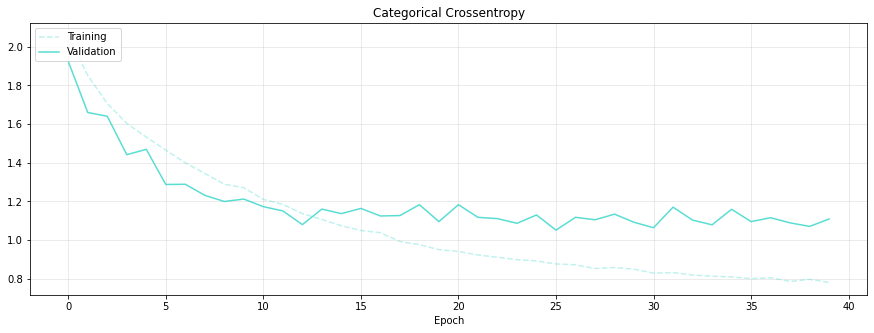

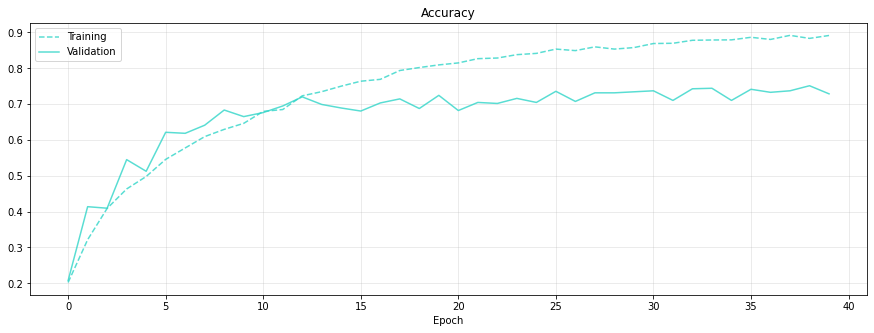

In [ ]:
#plots of the loss and accuracy evolving for each epoch
plt.figure(figsize=(15,5))
plt.plot(vgg_history['loss'], label='Training', alpha=.3, color='#30D5C8', linestyle='--')
plt.plot(vgg_history['val_loss'], label='Validation', alpha=.8, color='#30D5C8')
plt.legend(loc='upper left')
plt.xlabel('Epoch')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(vgg_history['accuracy'], label='Training', alpha=.8, color='#30D5C8', linestyle='--')
plt.plot(vgg_history['val_accuracy'], label='Validation', alpha=.8, color='#30D5C8')
plt.legend(loc='upper left')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# CNN with transfer learning


## Data Augmentation

Here we define the augmentations we want to perform on the data and also map them onto the training data. We use a keras_cv augmenter and a randAugment layer to uniformly choose different augmentations to perform. This is a technique proven to enhance performance of the network on validation data.

In [ ]:
#The augmenter contains all the augmentations we want to perform on the data.
augmenter = keras_cv.layers.Augmenter(
  layers=[
      keras_cv.layers.RandAugment(
        value_range=(0, 255), #describes the range of values covered in the images
        augmentations_per_image=3, # How many times we augment images
        magnitude=0.3, # describe the strength of the perturbations applied
        magnitude_stddev=0.2, #Allows magnitude to be randomly sampled from a distribution with a standard deviation of magnitude_stddev
        rate=0.5,), #indicates the probability to apply the augmentation applied at each layer.
      keras_cv.layers.CutMix(), #Add elements from one image to another to combat overfitting
      keras_cv.layers.MixUp() #Interpolates pixel values from one image onto another to combat overfitting
    ]
)

#The augment_data function takes the images and performs augmentations with the augmenter on each of them.
def augment_data(images, labels):
  inputs = {"images": images, "labels": labels}
  outputs = augmenter(inputs)
  return outputs['images'], outputs['labels']

In [ ]:
train_batched_ds = train_ds.batch(batch_size) #Now we batch data set and send 32 images at a time through the augmentation and the network.
aug_ds = train_batched_ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE) #Map the batched data onto the augmenter - we apply the augmentations to the batch of images in train_batched.
#Then we add augmentations two more times to get a large amount of augmentations for the training set.
aug_inflated_ds = aug_ds.concatenate(train_batched_ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE))
aug_inflated_ds = aug_inflated_ds.concatenate(train_batched_ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE))

In [ ]:
#Here we perform preprocessing steps to ensure the data will be of a format VGG16 accepts.
#This is done on both the training data and the validation data.
train_ds = train_ds.map(
  lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x), y))
aug_ds = aug_ds.map(
  lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x), y))
aug_inflated_ds = aug_inflated_ds.map(
  lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x), y))
val_ds = val_ds.map(
  lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x), y))

## Model Training


Here we create our model and training it.

In [ ]:
##We now define the input format for our network and import the VGG16 network pretrained on the
#dataset 'imagenet'. We then define the fine tuning functionaly of the network and create the rest
#of the network.
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):

      conv_base = VGG16(include_top=False,
                      weights='imagenet',
                      input_shape=input_shape)

      # The fine_tune param determines how many layers will be freezed from bottom and up
      if fine_tune > 0:
          for layer in conv_base.layers[:-fine_tune]:
              layer.trainable = False
      else:
          for layer in conv_base.layers:
              layer.trainable = False

      # Create a new 'top' of the model (i.e. fully-connected layers) for the classification after feature extraction.
      # This is 'bootstrapping' a new top_model onto the pretrained layers.
      top_model = conv_base.output
      top_model = Flatten(name="flatten")(top_model)
      top_model = Dense(4096, activation='relu')(top_model)
      top_model = Dropout(0.5)(top_model)
      output_layer = Dense(n_classes, activation='softmax')(top_model)

      # Group the convolutional base and new fully-connected layers into a Model object.
      model = Model(inputs=conv_base.input, outputs=output_layer)

      # Compile the model for training on our dataset.
      model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                    metrics=['accuracy'])

      return model

In [ ]:
#Here we define our learning rate decay and the optimizer and instantiate the model.
input_shape = (img_height, img_width, color_channels)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00007,
    decay_steps=100000,
    decay_rate=0.00003)


optim_1 = Adam(lr_schedule)


vgg_epochs = 200

vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=14)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping, patience is set to 20 to make sure the model can improve with such a high dropout rate.
#The earlystopping is here based on finding the minimum validation loss.
early_stop = EarlyStopping(monitor='val_loss',
                           patience=20,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
%%time

#Fit the model with all the defined parameters and on the augmented dataset.
vgg_history_transfer = vgg_model.fit(aug_inflated_ds,
                            batch_size=batch_size,
                            epochs=vgg_epochs,
                            validation_data=val_ds,
                            callbacks=[tl_checkpoint_1, early_stop],
                            verbose=1).history

Epoch 1/200
266/267 [============================>.] - ETA: 0s - loss: 2.0480 - accuracy: 0.2531
Epoch 1: val_loss improved from inf to 1.65331, saving model to tl_model_v1.weights.best.hdf5
267/267 [==============================] - 47s 133ms/step - loss: 2.0479 - accuracy: 0.2534 - val_loss: 1.6533 - val_accuracy: 0.5141
Epoch 2/200
267/267 [==============================] - ETA: 0s - loss: 1.9072 - accuracy: 0.3345
Epoch 2: val_loss improved from 1.65331 to 1.55342, saving model to tl_model_v1.weights.best.hdf5
267/267 [==============================] - 20s 71ms/step - loss: 1.9072 - accuracy: 0.3345 - val_loss: 1.5534 - val_accuracy: 0.4831
Epoch 3/200
266/267 [============================>.] - ETA: 0s - loss: 1.8737 - accuracy: 0.3653
Epoch 3: val_loss improved from 1.55342 to 1.39862, saving model to tl_model_v1.weights.best.hdf5
267/267 [==============================] - 20s 72ms/step - loss: 1.8737 - accuracy: 0.3651 - val_loss: 1.3986 - val_accuracy: 0.6215
Epoch 4/200
267/267

In [ ]:
vgg_model.save("content/savedmodels/vgg8") #Save the model for use on the test set.

## Results and Plots

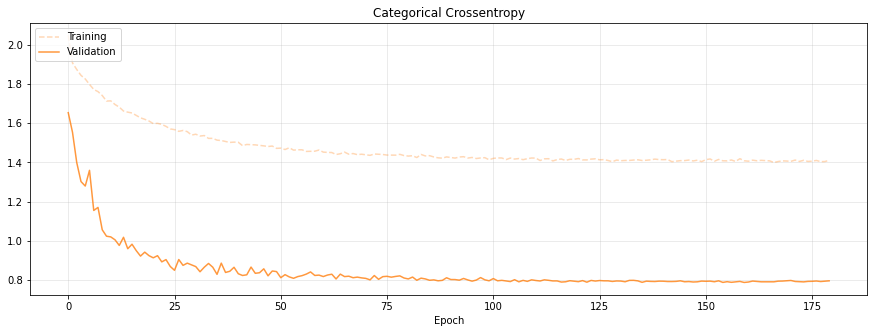

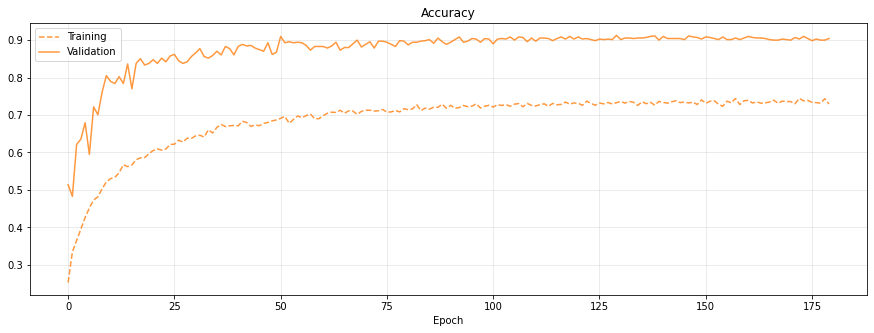

In [ ]:
#plots of the loss and accuracy evolving for each epoch
plt.figure(figsize=(15,5))
plt.plot(vgg_history_transfer['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(vgg_history_transfer['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.xlabel('Epoch')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(vgg_history_transfer['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(vgg_history_transfer['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()